<a href="https://colab.research.google.com/github/banuu0625/MA_Banu/blob/main/Chess_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
! pip install kaggle -q                         #install kaggle
! mkdir ~/.kaggle                               #make directory
! cp kaggle.json ~/.kaggle/                     #copy json file
! kaggle datasets download arevel/chess-games   #download chess games
! unzip -qq /content/chess-games.zip            #unzip file
! pip install chess -q #python chess package


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#install': Expected package name at the start of dependency specifier
    #install
    ^
Syntaxfehler.
Der Befehl "cp" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "kaggle" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "unzip" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#python': Expected package name at the start of dependency specifier
    #python
    ^


In [8]:
'chmod 600 /root/.kaggle/kaggle.json'

'chmod 600 /root/.kaggle/kaggle.json'

In [2]:


# General Imports
import re  # For regular expressions
import gc  # For garbage collection
import os  # For file operations
import numpy as np  # Numerical computations
import pandas as pd  # For loading and handling data
import chess  # Python-chess package to manage chess moves and rules
import pygame
import sys

# PyTorch Imports
import torch  # PyTorch core library
import torch.nn as nn  # Neural network layers and functions
import torch.nn.functional as F  # Non-linear activations like ReLU
from torch.utils.data import Dataset, DataLoader  # DataLoader and Dataset

# Matplotlib for visualization (optional)
import matplotlib.pyplot as plt  # For plotting results

pygame 2.6.0 (SDL 2.28.4, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Preprocessing the data

In [3]:
#column index mapping - change letters into numbers and vice versa
letter_2_num = {'a':0, 'b':1, 'c':2, 'd':3, 'e':4, 'f':5, 'g':6, 'h':7}
num_2_letter = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:'f', 6:'g', 7:'h'}

In [4]:
#Chess board to matrix

# Idea : CNN's can acces 3D inputs !
# Create feature map for each chess piece type {pawn, knight, bishop} , white pieces =1, black pieces =-1
# CNN board can learn the rule and make moves based on the state of the game




board = chess.Board()

def board_2_rep(board):   #board object from chess package
  pieces = ['p', 'r', 'n', 'b', 'q', 'k']
  layers = []
  for piece in pieces:
    layers.append(create_rep_layer(board, piece)) #create feature map for each chess type
  board_rep = np.stack(layers) #transform feature maps into 3D-tensor
  return board_rep


def create_rep_layer(board, type):

  s = str(board)
  s = re.sub(f'[^{type}{type.upper()} \n]', '.', s) #replace everything with a '.' EXCEPT[^] desired piece (e.g pawns -> p and P)
  s = re.sub(f'{type}', '-1', s)                    #replace black pawns with -1's
  s = re.sub(f'{type.upper()}','1',s)               #replace white pawns with 1's
  s = re.sub(f'\.', '0', s)                         #replace dots with 0's


  board_mat = []
  for row in s.split('\n'):                         #loop through lines
    row = row.split(' ')                            #split by whitespaces
    row = [int(x) for x in row]                     #replace string numbers with actual integers
    board_mat.append(row)                           #represend in np array

  return np.array(board_mat)


print(f'{board}\n')
board_2_rep(board)


r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R



array([[[ 0,  0,  0,  0,  0,  0,  0,  0],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  1,  1,  1,  1,  1,  1,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0]],

       [[-1,  0,  0,  0,  0,  0,  0, -1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  0,  0,  0,  0,  0,  0,  1]],

       [[ 0, -1,  0,  0,  0,  0, -1,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  1,  0,  0,  0,  

## **Represent a move**

In [5]:
# BASIC IDEA

#   "from matrix"             "to matrix"

# [[0 0 0 0 0 0 0 0]        [[0 0 0 0 0 0 0 0]
# [0 0 0 0 0 0 0 0]          [0 0 0 0 0 0 0 0]
# [0 0 0 0 0 0 0 0]          [0 0 0 0 0 0 0 0]
# [0 0 0 0 0 0 0 0]          [0 0 0 0 0 0 0 0]
# [0 0 0 0 0 0 0 0]          [0 0 0 0 0 1 0 0]
# [0 0 0 0 0 0 0 0]          [0 0 0 0 0 0 0 0]
# [0 0 0 0 1 0 0 0]          [0 0 0 0 0 0 0 0]
# [0 0 0 0 0 0 0 0]]         [0 0 0 0 0 0 0 0]]



def move_2_rep(move, board ):
  board.push_san(move).uci()                                    #convert dataset from SAN into UCI  format : 4 letters {d4e5}
  move = str(board.pop())

  from_output_layer = np.zeros((8,8))                           #create 2D array 8x8 zeros
  from_row = 8 - int(move[1])                                   #determine row
  from_column = letter_2_num[move[0]]                           #determine column, convert into number -> now we now the intial position(row,column)
  from_output_layer[from_row, from_column] = 1                  #convert 0 to 1 on determined position

  to_ouptut_layer = np.zeros((8,8))                             #create 2D array 8x8 zeros
  to_row = 8 - int(move[3])                                     #determine row
  to_column = letter_2_num[move[2]]                             #determine clomn -> we know the position the piece moves to
  to_ouptut_layer[to_row,to_column] = 1                         #convert 0 into a 1 on determined position

  return np.stack([from_output_layer, to_ouptut_layer])         #convert to a numpy array (stack = adding together)


move_2_rep('e2e4', board)




array([[[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]]])

## **clear SAN**

In [14]:
def create_move_list(s):
  return re.sub('\d*\. ', '',s).split(' ')[:-1]                 #dataset = 1. (move) 2. (move), we should clear numbers followed by . (e.g 1., 2., 3.) with a white space ('')





create_move_list('1. d4 d5 2. Nf3 Nf6 3. Bf4 c6 4. e3 Bg4 5.. Be2 Nbd7')

['d4', 'd5', 'Nf3', 'Nf6', 'Bf4', 'c6', 'e3', 'Bg4', '5.Be2']

### **The Raw Data**

In [ ]:

chess_data_raw = pd.read_csv('/content/chess_games.csv', usecols =['AN','WhiteElo']) #asses only the columns we need
chess_data = chess_data_raw[chess_data_raw['WhiteElo']> 2000] #filter by elo
del chess_data_raw #delete games which are less then required elo
gc.collect() #clear RAMSPACE
chess_data = chess_data[['AN']] # del 'WhiteElo'
chess_data = chess_data[~chess_data['AN'].str.contains('{')] #clear up characters which code can't handle
chess_data = chess_data[chess_data['AN'].str.len()>20] #clear too short games
print(chess_data.shape[0])

883376


In [ ]:
print(chess_data.head(10))

                                                    AN
7    1. d4 d5 2. Nf3 Nf6 3. Bf4 c6 4. e3 Bg4 5. Be2...
8    1. d4 Nf6 2. Bf4 e6 3. e3 d5 4. Nf3 h6 5. Bd3 ...
13   1. b4 e6 2. Bb2 d5 3. Nf3 Nf6 4. b5 Be7 5. e3 ...
26   1. e4 d6 2. d4 Nf6 3. Bd3 g6 4. h4 c5 5. h5 Nx...
39   1. e4 e6 2. d4 d5 3. Nc3 Bb4 4. e5 c5 5. a3 cx...
44   1. d4 d5 2. Nc3 c6 3. Nf3 Nf6 4. Bg5 e6 5. e3 ...
75   1. Nf3 Nc6 2. d4 e5 3. e3 exd4 4. Nxd4 d5 5. N...
85   1. d4 Nf6 2. Nf3 e6 3. g3 d5 4. Bg2 c5 5. O-O ...
104  1. Nc3 d5 2. b3 d4 3. Ne4 f5 4. Ng3 f4 5. Ne4 ...
109  1. e4 Nc6 2. Nf3 d6 3. d4 Nf6 4. Nc3 g6 5. Bd3...


## **PyTorch Classes**

In [5]:
class ChessDataset(Dataset):
  def __init__(self,games):
    super(ChessDataset, self).__init__() #call the constructor of its parent class
    self.games = games
    
  def __len__(self):
      return 40_000 #use 40k games, because moves are randomly selected anyway (save data?)

  def __getitem__(self, index):
    game_i = np.random.randint(self.games.shape[0]) #random integer from "Dataset" (Where did Dataset come from, what is the function of it?)
    random_game = chess_data['AN'].values[game_i]   #this integer = random game
    moves = create_move_list(random_game) #clean up notation by calling above created function
    game_state_i = np.random.randint(len(moves)-1) #pick random move, and -1
    next_move = moves[game_state_i] #next move is game_state_i + 1
    moves = moves[:game_state_i] #all moves until current move
    board = chess.Board()
    for move in moves :
      board.push_san(move)  #loop through all moves

    x = board_2_rep(board) #above function for feature map of every position
    y = move_2_rep(next_move, board)  #feature map for played move
    if game_state_i % 2 == 1: #always play positive values
      x*= -1
    return x, y




## **Dataloader**

In [9]:
data_train = ChessDataset(chess_data['AN'])                                                 #training data with moves
data_train_loader = DataLoader(data_train, batch_size = 32, shuffle = True, drop_last=True) # 40000/32 = mini-batches with 1250 games each. shuffle for randomnes, drop last minibatch if not correct size


NameError: name 'chess_data' is not defined

## **CNN**

In [6]:
#Network = several modules one after another

class Module(nn.Module):
    def __init__(self, hidden_size):
        super(Module, self).__init__()
        self.conv1 = nn.Conv2d(hidden_size, hidden_size, 3, stride=1, padding=1)          #2 convolutional layers = extract feautres, patterns
        self.conv2 = nn.Conv2d(hidden_size, hidden_size, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_size)                                            # batch normalisation layers = reduce overfitting and improve the generalization ability of the model
        self.bn2 = nn.BatchNorm2d(hidden_size)
        self.activation1 = nn.SELU()                                                      #activation function for to add non-linearity into the model,
        self.activation2 = nn.SELU()

    def forward(self, x):
        x_input = torch.clone(x)                                                          # Clone input for skip connection
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = x + x_input                                                                   # Residual connection, should improve learning
        x = self.activation2(x)
        return x

class ChessNet(nn.Module):
    def __init__(self, hidden_layers=4, hidden_size=200):
        super(ChessNet, self).__init__()
        self.hidden_layers = hidden_layers
        self.input_layer = nn.Conv2d(6, hidden_size, 3, stride=1, padding=1)
        self.module_list = nn.ModuleList([Module(hidden_size) for i in range(hidden_layers)]) #ModuleList connected with above "Module"
        self.output_layer = nn.Conv2d(hidden_size, 2, 3, stride=1, padding=1)

    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)

        for i in range(self.hidden_layers):
            x = self.module_list[i](x)

        x = self.output_layer(x)

        return x






## **Losses**

In [11]:
# Assume we have already defined the neural network model as `chess_net`
model = ChessNet(hidden_layers=4, hidden_size=200).to('cuda')  # Make sure the model is on the GPU
x, y = next(iter(data_train_loader))  # Sample from DataLoader
x, y = x.float().to('cuda'), y.to('cuda')     # Move data to GPU

# Forward pass through the model
output = model(x)

# Loss calculation
metric_from = nn.CrossEntropyLoss()
metric_to = nn.CrossEntropyLoss()

# Calculating the loss for "from" and "to" positions
loss_from = metric_from(output[:,0,:], y[:,0,:])
loss_to = metric_to(output[:,1,:], y[:,1,:])
loss = loss_from + loss_to


AssertionError: Torch not compiled with CUDA enabled

## **Picking moves**

In [7]:
def check_mate_single(board):
  board = board.copy()
  legal_moves = list(board.legal_moves)
  for move in legal_moves:
    board.push_uci(str(move))
    if board.is_checkmate():
      move = board.pop()
      return move
    _ = board.pop()


def distribution_over_moves(vals):
  probs = np.array(vals)
  probs = np.exp(probs)
  probs = probs/probs.sum()
  probs = probs ** 3
  probs = probs /probs.sum()
  return probs

# Predict function
def predict(x):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculations for inference
        output = model(x)
    return output



def choose_move(board, player, color):
    legal_moves = list(board.legal_moves)

    # Check for immediate checkmate
    move = check_mate_single(board)
    if move is not None:
        return move

    # Prepare the input for the model
    x = torch.Tensor(board_2_rep(board)).float().to('cuda')
    if color == chess.BLACK:
        x *= -1
    x = x.unsqueeze(0)  # Add batch dimension
    move = predict(x)  # Model prediction, should return (1, 2, 8, 8)

    # Move output to CPU for NumPy operations
    move = move.cpu()

    vals = []
    froms = [str(legal_move)[:2] for legal_move in legal_moves]
    froms = list(set(froms))

    for from_ in froms:
        rank = 8 - int(from_[1])  # Convert rank to index (0-7)
        file = letter_2_num[from_[0]]  # Convert file (a-h) to index (0-7)

        # Ensure indexing is correct for the "from" predictions
        val = move[0, 0, rank, file].item()  # Convert tensor to scalar for compatibility with NumPy
        vals.append(val)

    # Convert values to probability distribution
    probs = distribution_over_moves(vals)

    # Choose a "from" square based on probabilities
    choosen_from = str(np.random.choice(froms, size=1, p=probs)[0])[:2]

    vals = []
    for legal_move in legal_moves:
        from_ = str(legal_move)[:2]
        if from_ == choosen_from:
            to = str(legal_move)[2:]
            rank_to = 8 - int(to[1])  # Convert rank to index
            file_to = letter_2_num[to[0]]  # Convert file to index

            # Ensure indexing is correct for the "to" predictions
            val = move[0, 1, rank_to, file_to].item()  # Convert tensor to scalar for compatibility with NumPy
            vals.append(val)
        else:
            vals.append(0)

    # Choose the final move based on the highest value in 'to' position predictions
    choosen_move = legal_moves[np.argmax(vals)]
    return choosen_move




def self_play_evaluation(board, model, color=chess.WHITE):
    # Reset the board and play a game
    board.reset()
    player = 1 if color == chess.WHITE else -1

    for move_num in range(100):  # Simulate up to 100 moves, or stop earlier if game ends
        move = choose_move(board, player, color)  # Use model to choose move
        if move is not None:
            board.push(move)  # Make the chosen move
        else:
            print(f"No legal moves available. Game over after {move_num} moves.")
            break

        if board.is_game_over():
            print(f"Game over after {move_num} moves. Result: {board.result()}")
            break

        # Switch player and color for the next move
        player *= -1
        color = chess.BLACK if color == chess.WHITE else chess.WHITE

    return board

## Train **Model**

In [3]:
import torch.optim as optim

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # model is your neural network



num_epochs = 100
# After each epoch
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (x, y) in enumerate(data_train_loader):
        x, y = x.float().to('cuda'), y.to('cuda')

        optimizer.zero_grad()
        output = model(x)

        loss_from = metric_from(output[:, 0, :], y[:, 0])
        loss_to = metric_to(output[:, 1, :], y[:, 1])

        loss = loss_from + loss_to
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(data_train_loader)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

    # After each epoch, run self-play for evaluation
    print(f"Evaluating model after epoch {epoch + 1}")
    board = chess.Board()
    final_board = self_play_evaluation(board, model, color=chess.WHITE)
    print(final_board)

# Save the model parameters
torch.save(model.state_dict(), 'chess_net.pth')


NameError: name 'model' is not defined

## **Evaluation**

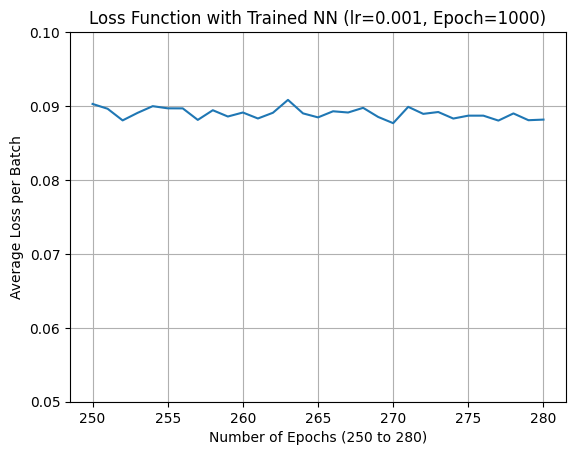

In [26]:
# List of values provided
values = [
    0.0925, 0.0926, 0.0888, 0.0920, 0.0900, 0.0861, 0.0876, 0.0912, 0.0891, 0.0949, 0.0898, 0.0888,
    0.0902, 0.0868, 0.0935, 0.0930, 0.0878, 0.0903, 0.0865, 0.0910, 0.0881, 0.0882, 0.0882, 0.0920,
    0.0859, 0.0892, 0.0911, 0.0882, 0.0880, 0.0913, 0.0849, 0.0902, 0.0864, 0.0877, 0.0861, 0.0877,
    0.0862, 0.0889, 0.0895, 0.0911, 0.0889, 0.0848, 0.0917, 0.0899, 0.0883, 0.0921, 0.0901, 0.0875,
    0.0886, 0.0924, 0.0936, 0.0896, 0.0916, 0.0856, 0.0900, 0.0907, 0.0898, 0.0901, 0.0917, 0.0861,
    0.0885, 0.0868, 0.0898, 0.0876, 0.0943, 0.0911, 0.0920, 0.0938, 0.0861, 0.0891, 0.0884, 0.0888,
    0.0925, 0.0890, 0.0902, 0.0904, 0.0924, 0.0860, 0.0884, 0.0904, 0.0940, 0.0861, 0.0898, 0.0870,
    0.0909, 0.0862, 0.0870, 0.0857, 0.0897, 0.0892, 0.0852, 0.0868, 0.0910, 0.0901, 0.0888, 0.0869,
    0.0905, 0.0918, 0.0887, 0.0916, 0.0858, 0.0906, 0.0883, 0.0908, 0.0895, 0.0910, 0.0884, 0.0862,
    0.0860, 0.0891, 0.0874, 0.0871, 0.0862, 0.0881, 0.0900, 0.0859, 0.0925, 0.0887, 0.0909, 0.0911,
    0.0869, 0.0862, 0.0925, 0.0881, 0.0924, 0.0877, 0.0884, 0.0895, 0.0908, 0.0879, 0.0870, 0.0921,
    0.0858, 0.0873, 0.0907, 0.0868, 0.0921, 0.0908, 0.0861, 0.0872, 0.0898, 0.0870, 0.0915, 0.0847,
    0.0889, 0.0907, 0.0870, 0.0869, 0.0885, 0.0899, 0.0898, 0.0893, 0.0882, 0.0864, 0.0921, 0.0914,
    0.0919, 0.0925, 0.0906, 0.0925, 0.0901, 0.0909, 0.0928, 0.0924, 0.0905, 0.0886, 0.0894, 0.0878,
    0.0882, 0.0866, 0.0901, 0.0867, 0.0893, 0.0886, 0.0910, 0.0934, 0.0854, 0.0934, 0.0885, 0.0869,
    0.0864, 0.0883, 0.0900, 0.0905, 0.0878, 0.0913, 0.0900, 0.0871, 0.0857, 0.0848, 0.0900, 0.0897,
    0.0860, 0.0901, 0.0903, 0.0924, 0.0904, 0.0908, 0.0854, 0.0913, 0.0867, 0.0921, 0.0878, 0.0882,
    0.0877, 0.0905, 0.0848, 0.0909, 0.0845, 0.0887, 0.0892, 0.0917, 0.0921, 0.0883, 0.0921, 0.0890,
    0.0919, 0.0878, 0.0944, 0.0913, 0.0887, 0.0879, 0.0864, 0.0891, 0.0934, 0.0871, 0.0913, 0.0878,
    0.0870, 0.0871, 0.0896, 0.0892, 0.0866, 0.0887, 0.0886, 0.0907, 0.0885, 0.0910, 0.0898, 0.0855,
    0.0905, 0.0895, 0.0852, 0.0877, 0.0898, 0.0883, 0.0846, 0.0872, 0.0881, 0.0880, 0.0863, 0.0870,
    0.0905, 0.0928, 0.0928, 0.0858, 0.0913, 0.0898, 0.0867, 0.0919, 0.0864, 0.0902, 0.0913, 0.0892,
    0.0920, 0.0891, 0.0879, 0.0899, 0.0876, 0.0870, 0.0901, 0.0888, 0.0902, 0.0840, 0.0895, 0.0912,
    0.0912, 0.0900, 0.0909, 0.0910, 0.0857, 0.0853, 0.0885, 0.0882, 0.0918, 0.0872, 0.0877, 0.0928,
    0.0865, 0.0857, 0.0918, 0.0878, 0.0880, 0.0929, 0.0885, 0.0867, 0.0851, 0.0902, 0.0874, 0.0891,
    0.0895, 0.0851, 0.0926, 0.0843, 0.0874, 0.0912, 0.0905, 0.0915, 0.0890, 0.0881, 0.0869, 0.0883,
    0.0895, 0.0851, 0.0926, 0.0843, 0.0874, 0.0912, 0.0905, 0.0915, 0.0890, 0.0881, 0.0869, 0.0883,
    0.0882, 0.0885, 0.0875, 0.0870, 0.0867, 0.0863, 0.0864, 0.0926, 0.0884, 0.0879, 0.0897, 0.0872,
    0.0908, 0.0913, 0.0869, 0.0873, 0.0861, 0.0888, 0.0866, 0.0907, 0.0869, 0.0909, 0.0911, 0.0906,
    0.0888, 0.0911, 0.0887, 0.0884, 0.0891, 0.0897, 0.0872, 0.0857, 0.0876, 0.0865, 0.0862, 0.0880,
    0.0885, 0.0881, 0.0914, 0.0888, 0.0847, 0.0887, 0.0870, 0.0925, 0.0855, 0.0865, 0.0899, 0.0864,
    0.0878, 0.0864, 0.0860, 0.0875, 0.0910, 0.0877, 0.0860, 0.0864, 0.0887, 0.0880, 0.0912, 0.0910
]

# Function to calculate the average for every 12 value
epoch_value = 0
averages = []
i = 0

while i < int(len(values)-1):
    epoch_value += values[i]
    i+= 1

    if i % 12 == 0:
        averages.append(epoch_value/12)
        epoch_value = 0

numb = []
for i in range(250,281):
    numb.append(i)

import matplotlib.pyplot as plt

# Assuming `losses` is a list of average loss per epoch
plt.plot(numb, averages)
plt.ylabel("Average Loss per Batch")
plt.xlabel("Number of Epochs (250 to 280)")
plt.title("Loss Function with Trained NN (lr=0.001, Epoch=1000)")
plt.grid(True)
plt.ylim(0.05, 0.1)  # Set the y-axis range from 0 to 1
plt.show()



## **UI**

In [11]:
# General Imports
import re  # For regular expressions
import gc  # For garbage collection
import os  # For file operations
import numpy as np  # Numerical computations
import pandas as pd  # For loading and handling data
import chess  # Python-chess package to manage chess moves and rules
import pygame
import sys #module which works with the interpreter

# PyTorch Imports
import torch  # PyTorch core library
import torch.nn as nn  # Neural network layers and functions
import torch.nn.functional as F  # Non-linear activations like ReLU
from torch.utils.data import Dataset, DataLoader  # DataLoader and Dataset
import asyncio

# Matplotlib for visualization (optional)
import matplotlib.pyplot as plt  # For plotting results

#################################################################################################################################################################################
#################################################################################################################################################################################
#################################################################################################################################################################################
#################################################################################################################################################################################
board = chess.Board()

def board_2_rep(board):   #board object from chess package
  pieces = ['p', 'r', 'n', 'b', 'q', 'k']
  layers = []
  for piece in pieces:
    layers.append(create_rep_layer(board, piece)) #create feature map for each chess type
  board_rep = np.stack(layers) #transform feature maps into 3D-tensor
  return board_rep


def create_rep_layer(board, type):

  s = str(board)
  s = re.sub(f'[^{type}{type.upper()} \n]', '.', s) #replace everything with a '.' EXCEPT[^] desired piece (e.g pawns -> p and P)
  s = re.sub(f'{type}', '-1', s)                    #replace black pawns with -1's
  s = re.sub(f'{type.upper()}','1',s)              #replace white pawns with 1's
  s = re.sub(f'\.', '0', s)                         #replace dots with 0's


  board_mat = []
  for row in s.split('\n'):                         #loop through lines
    row = row.split(' ')                            #split by whitespaces
    row = [int(x) for x in row]                     #replace string numbers with actual integers
    board_mat.append(row)                           #represend in np array

  return np.array(board_mat)


#column index mapping - change letters into numbers and vice versa
letter_2_num = {'a':0, 'b':1, 'c':2, 'd':3, 'e':4, 'f':5, 'g':6, 'h':7}
num_2_letter = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:'f', 6:'g', 7:'h'}

#################################################################################################################################################################################
#################################################################################################################################################################################
#################################################################################################################################################################################
#################################################################################################################################################################################

pygame.init()

# Chessboard constants
BOARD_WIDTH, BOARD_HEIGHT = 800, 800
MARGIN = 50
SQUARE_SIZE = BOARD_WIDTH // 8

# Screen size
SCREEN_WIDTH = BOARD_WIDTH + 2 * MARGIN
SCREEN_HEIGHT = BOARD_HEIGHT + 2 * MARGIN

# Colors
WHITE = (232, 235, 234)
BLACK = (125, 135, 150)
GREEN = (36, 232, 19)

# Create the screen
screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
pygame.display.set_caption("Chess Game")

# Chess piece class to build the individual chess pieces
class ChessPiece:
    def __init__(self, color, type, image):
        self.color = color
        self.type = type
        self.image = pygame.image.load(image)
        self.image = pygame.transform.scale(self.image, (SQUARE_SIZE, SQUARE_SIZE))
        self.has_moved = False

# Initialize the board
board = [[None for _ in range(8)] for _ in range(8)]

#[[None, None, None, None, None, None, None, None],
#[None, None, None, None, None, None, None, None],     col
#[None, None, None, None, None, None, None, None],      ^
#[None, None, None, None, None, None, None, None],      |
#[None, None, None, None, None, None, None, None],      -> row
#[None, None, None, None, None, None, None, None],
#[None, None, None, None, None, None, None, None],
#[None, None, None, None, None, None, None, None]]

game_board = chess.Board()  # This will handle all valid move checking and game state

# r n b q k b n r
# p p p p p p p p
# . . . . . . . .
# . . . . . . . .
# . . . . . . . .
# . . . . . . . .
# P P P P P P P P
# R N B Q K B N R


# Selected piece
selected_piece = None
selected_pos = None
valid_moves = []  # List of valid moves for the currently selected piece

# Initialize the chess board with pieces using created class
def init_board():
    # Pawns
    for col in range(8):
        board[1][col] = ChessPiece('black', 'pawn', 'Chessgame/images/black_pawn.png')
        board[6][col] = ChessPiece('white', 'pawn', 'Chessgame/images/white_pawn.png')

    # Rooks
    board[0][0] = board[0][7] = ChessPiece('black', 'rook', 'Chessgame/images/black_rook.png')
    board[7][0] = board[7][7] = ChessPiece('white', 'rook', 'Chessgame/images/white_rook.png')

    # Knights
    board[0][1] = board[0][6] = ChessPiece('black', 'knight', 'Chessgame/images/black_knight.png')
    board[7][1] = board[7][6] = ChessPiece('white', 'knight', 'Chessgame/images/white_knight.png')

    # Bishops
    board[0][2] = board[0][5] = ChessPiece('black', 'bishop', 'Chessgame/images/black_bishop.png')
    board[7][2] = board[7][5] = ChessPiece('white', 'bishop', 'Chessgame/images/white_bishop.png')

    # Queens
    board[0][3] = ChessPiece('black', 'queen', 'Chessgame/images/black_queen.png')
    board[7][3] = ChessPiece('white', 'queen', 'Chessgame/images/white_queen.png')

    # Kings
    board[0][4] = ChessPiece('black', 'king', 'Chessgame/images/black_king.png')
    board[7][4] = ChessPiece('white', 'king', 'Chessgame/images/white_king.png')


# Draw the chessboard
def draw_board():
    for row in range(8):
        for col in range(8):
            color = WHITE if (row + col) % 2 == 0 else BLACK #alternating colour
            pygame.draw.rect(screen, color, (col * SQUARE_SIZE + MARGIN, row * SQUARE_SIZE + MARGIN, SQUARE_SIZE, SQUARE_SIZE))
    
    # Highlight the selected square if any
    if selected_pos:
        pygame.draw.rect(screen, GREEN, (selected_pos[1] * SQUARE_SIZE + MARGIN, selected_pos[0] * SQUARE_SIZE + MARGIN, SQUARE_SIZE, SQUARE_SIZE))

# Draw the chess pieces on the board
def draw_pieces():
    for row in range(8):
        for col in range(8):
            piece = board[row][col]
            if piece:
                screen.blit(piece.image, (col * SQUARE_SIZE + MARGIN, row * SQUARE_SIZE + MARGIN)) #put image for every position in board[row][col], defined in function above

# Function to draw the labels 
def draw_labels():
    font = pygame.font.SysFont(None, 36)
    
    # Letters (A to H) - for top and bottom
    letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    for i in range(8):
        # Draw at the top
        text = font.render(letters[i], True, WHITE)
        screen.blit(text, (i * SQUARE_SIZE + MARGIN + SQUARE_SIZE // 2 - text.get_width() // 2, MARGIN // 4)) 
        
        # Draw at the bottom
        screen.blit(text, (i * SQUARE_SIZE + MARGIN + SQUARE_SIZE // 2 - text.get_width() // 2, SCREEN_HEIGHT - MARGIN // 1.5)) 
    
    # Numbers (1 to 8) - for left and right
    for i in range(8):
        text = font.render(str(8 - i), True, WHITE)
        
        # Draw on the left
        screen.blit(text, (MARGIN // 4, i * SQUARE_SIZE + MARGIN + SQUARE_SIZE // 2 - text.get_height() // 2)) 
        
        # Draw on the right
        screen.blit(text, (SCREEN_WIDTH - MARGIN // 1.5, i * SQUARE_SIZE + MARGIN + SQUARE_SIZE // 2 - text.get_height() // 2))


def handle_click(pos, color=chess.WHITE, promotion_choice=None):
    global selected_piece, selected_pos, valid_moves, initial_square, move_uci

    # Check if the click is within the actual board area, considering margins
    if MARGIN <= pos[0] < SCREEN_WIDTH - MARGIN and MARGIN <= pos[1] < SCREEN_HEIGHT - MARGIN:
        # Convert pixel position to board coordinates (row, col), taking margin into account
        col = (pos[0] - MARGIN) // SQUARE_SIZE
        row = (pos[1] - MARGIN) // SQUARE_SIZE

        # Mapping to get chess notation for clicked square
        letter_2_num = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7}
        num_2_letter = {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h'}
        clicked_square = f'{num_2_letter[col]}{8 - row}'

        # If no piece is selected, attempt to select one
        if selected_piece is None:
            piece = board[row][col]
            if piece and piece.color == 'white':  # Ensure correct player's turn
                selected_piece = piece
                selected_pos = (row, col)
                valid_moves = get_valid_moves(game_board, clicked_square)  # Retrieve valid moves for the selected piece
                print(f"Piece selected at {clicked_square}. Valid moves: {[move[-2:] for move in valid_moves]}")
                initial_square = clicked_square
        else:
            # Try moving the selected piece
            target_square = clicked_square
            if target_square in [move[-2:] for move in valid_moves]:  # Check if move is valid
                # Make the move in game logic
                game_move = [move for move in valid_moves if move.endswith(target_square)][0]
                game_board.push_uci(game_move)
                print(f"Moved piece from {game_move[:2]} to {target_square}.")

                # Handle castling
                if game_move == "e1g1":  # White kingside castling
                    board[7][6] = board[7][4]  # Move king
                    board[7][5] = board[7][7]  # Move rook
                    board[7][4] = None
                    board[7][7] = None
                    print("Castled King Side")
                elif game_move == "e1c1":  # White queenside castling
                    board[7][2] = board[7][4]  # Move king
                    board[7][3] = board[7][0]  # Move rook
                    board[7][4] = None
                    board[7][0] = None
                    print("Castled Queen Side")
                
                elif target_square[-2:] == ('a8', 'b8', 'c8', 'd8', 'e8', 'f8', 'g8', 'h8') and board[row][col] == ChessPiece('white', 'pawn', 'Chessgame/images/white_pawn.png'):

                    if promotion_choice is None:
                        promotion_choice = 'q'  # Default to queen
                    elif promotion_choice.lower() not in ['q', 'r', 'b', 'n']:
                        print("Invalid promotion choice. Defaulting to queen.")
                        promotion_choice = 'q'
                    
                    # Modify the move with the promotion choice
                    game_move = game_move[:-1] + promotion_choice.lower()

                    # Push the move to the game board
                    game_board.push_uci(game_move)
                    print(f"Moved piece from {game_move[:2]} to {target_square} with promotion to {promotion_choice.upper() if promotion_choice else 'Q'}.")

                    # Update visual board
                    board[row][col] = promotion_choice.upper() if game_move.endswith(('q', 'r', 'b', 'n')) else selected_piece
                    selected_row, selected_col = selected_pos
                    board[selected_row][selected_col] = None

                    # Reset selection
                    selected_piece = None
                    selected_pos = None
                    valid_moves = []              

                else:
                    # Update visual board for normal moves
                    board[row][col] = selected_piece
                    selected_row, selected_col = selected_pos
                    board[selected_row][selected_col] = None

                # Reset selection
                selected_piece = None
                selected_pos = None
                valid_moves = []
            else:
                print("Invalid move. Select another square.")
                # Reset selection if invalid move
                selected_piece = None
                selected_pos = None
                valid_moves = []







# Get valid moves using python-chess
def get_valid_moves(board, position):
    square = chess.parse_square(position)
    piece = board.piece_at(square)
    if piece is None:
        return []  # No piece at the position

    # Get all legal moves for the piece on that square
    legal_moves = [move for move in board.legal_moves if move.from_square == square]
    return [move.uci() for move in legal_moves]

#################################################################################################################################################################################
#################################################################################################################################################################################
#################################################################################################################################################################################
#################################################################################################################################################################################




class Module(nn.Module):
    def __init__(self, hidden_size):
        super(Module, self).__init__()
        self.conv1 = nn.Conv2d(hidden_size, hidden_size, 3, stride=1, padding=1)          #2 convolutional layers = extract feautres, patterns
        self.conv2 = nn.Conv2d(hidden_size, hidden_size, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_size)                                            # batch normalisation layers = reduce overfitting and improve the generalization ability of the model
        self.bn2 = nn.BatchNorm2d(hidden_size)
        self.activation1 = nn.SELU()                                                      #activation function for to add non-linearity into the model,
        self.activation2 = nn.SELU()

    def forward(self, x):
        x_input = torch.clone(x)                                                          # Clone input for skip connection
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = x + x_input                                                                   # Residual connection, should improve learning
        x = self.activation2(x)
        return x

class ChessNet(nn.Module):
    def __init__(self, hidden_layers=4, hidden_size=200):
        super(ChessNet, self).__init__()
        self.hidden_layers = hidden_layers
        self.input_layer = nn.Conv2d(6, hidden_size, 3, stride=1, padding=1)
        self.module_list = nn.ModuleList([Module(hidden_size) for i in range(hidden_layers)]) #ModuleList connected with above "Module"
        self.output_layer = nn.Conv2d(hidden_size, 2, 3, stride=1, padding=1)

    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)

        for i in range(self.hidden_layers):
            x = self.module_list[i](x)

        x = self.output_layer(x)

        return x

#################################################################################################################################################################################
#################################################################################################################################################################################
#################################################################################################################################################################################
#################################################################################################################################################################################

model = ChessNet(hidden_layers=4, hidden_size=200)
model.load_state_dict(torch.load('NNs\chess_net250.pth', map_location='cpu', weights_only=True))
model.eval()




def check_mate_single(board):
  board = board.copy()
  legal_moves = list(board.legal_moves)
  for move in legal_moves:
    board.push_uci(str(move))
    if board.is_checkmate():
      move = board.pop()
      return move
    _ = board.pop()


def distribution_over_moves(vals):
  probs = np.array(vals)
  probs = np.exp(probs)
  probs = probs/probs.sum()
  probs = probs ** 3
  probs = probs /probs.sum()
  return probs

# Predict function
def predict(x):
     # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculations for inference
        output = model(x)
    return output

def choose_move(board, color=chess.BLACK):
    legal_moves = list(board.legal_moves)

    # Check for immediate checkmate
    move = check_mate_single(board)
    if move is not None:
        return move

    # Prepare the input for the model
    x = torch.Tensor(board_2_rep(board)).float()  # Use CPU instead
    if color == chess.BLACK:
        x *= -1
    x = x.unsqueeze(0)  # Add batch dimension
    move = predict(x)  # Model prediction, should return (1, 2, 8, 8)

    # Move output to CPU for NumPy operations
    move = move.cpu()

    vals = []
    froms = [str(legal_move)[:2] for legal_move in legal_moves]
    froms = list(set(froms))

    for from_ in froms:
        rank = 8 - int(from_[1])  # Convert rank to index (0-7)
        file = letter_2_num[from_[0]]  # Convert file (a-h) to index (0-7)

        # Ensure indexing is correct for the "from" predictions
        val = move[0, 0, rank, file].item()  # Convert tensor to scalar for compatibility with NumPy
        vals.append(val)

    # Convert values to probability distribution
    probs = distribution_over_moves(vals)

    # Choose a "from" square based on probabilities
    choosen_from = str(np.random.choice(froms, size=1, p=probs)[0])[:2]

    vals = []
    for legal_move in legal_moves:
        from_ = str(legal_move)[:2]
        if from_ == choosen_from:
            to = str(legal_move)[2:]
            rank_to = 8 - int(to[1])  # Convert rank to index
            file_to = letter_2_num[to[0]]  # Convert file to index

            # Ensure indexing is correct for the "to" predictions
            val = move[0, 1, rank_to, file_to].item()  # Convert tensor to scalar for compatibility with NumPy
            vals.append(val)
        else:
            vals.append(0)

    # Choose the final move based on the highest value in 'to' position predictions
    choosen_move = legal_moves[np.argmax(vals)]
    return choosen_move.uci()
    

def NN_move():
    """
    Executes the AI's chosen move, updating both the visual board and the game logic board.
    """
    global game_board, board

    # Get the move chosen by the AI
    move_uci = choose_move(game_board, chess.BLACK)
    if not move_uci:
        print("AI could not make a move.")
        return
    
    
    # Convert UCI move to source and destination squares
    move = chess.Move.from_uci(move_uci)
    from_square = move.from_square
    to_square = move.to_square

    # Convert to (row, col) for the visual board
    from_row, from_col = 7 - (from_square // 8), from_square % 8
    to_row, to_col = 7 - (to_square // 8), to_square % 8



    if move_uci == "e8g8":  # Black kingside castling
        game_board.push(move)
        board[0][6] = board[0][4]  # Move king
        board[0][5] = board[0][7]  # Move rook
        board[0][4] = None
        board[0][7] = None
        print("Castled King Side")
    
    elif move_uci == "e8c8":  # Black queenside castling
        game_board.push(move)
        board[0][2] = board[0][4]  # Move king
        board[0][3] = board[0][0]  # Move rook
        board[0][4] = None
        board[0][0] = None
        game_board.push(move)
        print("Castled Queen Side")
        
    else:
        # Update python-chess board
        game_board.push(move)

        # Update visual board
        board[to_row][to_col] = board[from_row][from_col]  # Move piece
        board[from_row][from_col] = None  # Clear original square

        # Debug information
        print(f"AI moved piece from ({from_row}, {from_col}) to ({to_row}, {to_col}) using UCI: {move_uci}")





# Game loop
async def game_loop():

    init_board()
    while True:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                sys.exit()

            elif event.type == pygame.MOUSEBUTTONDOWN:
                handle_click(pygame.mouse.get_pos())  # White's turn (human)
                if game_board.turn == chess.BLACK:  # If it's now Black's turn
                    NN_move()   # Make the NN move for black 
                  
        # Redraw the board and pieces
        screen.fill((0, 0, 0))
        draw_labels()
        draw_board()
        draw_pieces()
        # Update the screen
        pygame.display.flip()
        await asyncio.sleep(0)  

asyncio.run(game_loop())

Piece selected at e2. Valid moves: ['e3', 'e4']
Moved piece from e2 to e4.
AI moved piece from (1, 4) to (3, 4) using UCI: e7e5
Piece selected at f2. Valid moves: ['f3', 'f4']
Moved piece from f2 to f3.
AI moved piece from (1, 3) to (3, 3) using UCI: d7d5
Piece selected at b1. Valid moves: ['c3', 'a3']
Moved piece from b1 to c3.
AI moved piece from (3, 3) to (4, 4) using UCI: d5e4
Piece selected at f3. Valid moves: ['e4', 'f4']
Moved piece from f3 to e4.
AI moved piece from (0, 6) to (2, 5) using UCI: g8f6
Piece selected at f1. Valid moves: ['a6', 'b5', 'c4', 'd3', 'e2']
Moved piece from f1 to c4.
AI moved piece from (0, 5) to (4, 1) using UCI: f8b4
Piece selected at d1. Valid moves: ['h5', 'g4', 'f3', 'e2']
Moved piece from d1 to e2.
AI moved piece from (0, 3) to (1, 4) using UCI: d8e7
Piece selected at c3. Valid moves: ['d5', 'b5', 'a4', 'd1', 'b1']
Moved piece from c3 to d5.
AI moved piece from (2, 5) to (3, 3) using UCI: f6d5
Piece selected at e4. Valid moves: ['d5']
Moved piece fr

SystemExit: 

C:\Users\banui\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
